In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils import data

from tqdm.notebook import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

device = torch.device("mps" if torch.has_mps else "cpu")
print(device)
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from aif360.algorithms.postprocessing import (CalibratedEqOddsPostprocessing,
                                              EqOddsPostprocessing,
                                              RejectOptionClassification)
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector
random_state = 1

mps


pip install 'aif360[AdversarialDebiasing]'


In [2]:
# read in data and split
X = torch.load('inputs/logistic_regression_inputs.pt').cpu()
y = torch.load('inputs/logistic_regression_labels.pt').cpu()
df = pd.read_csv('inputs/logistic_regression_df.csv')
gender = df['reference_gender']
ethnicity = df['reference_ethnicity']
#extract black and white data points
df = df[(ethnicity=='black') | (ethnicity=='white')].reset_index()
X = X[(ethnicity=='black') | (ethnicity=='white')]
y = y[(ethnicity=='black') | (ethnicity=='white')]
gender = gender[(ethnicity=='black') | (ethnicity=='white')].to_numpy()
ethnicity = ethnicity[(ethnicity=='black') | (ethnicity=='white')].to_numpy()

df

,index,reference_identity,candidate_identity,reference_ethnicity,candidate_ethnicity,reference_gender,candidate_gender,labels
0,2400,n009001,n009001,black,black,male,male,1.0
1,2401,n009001,n009001,black,black,male,male,1.0
2,2402,n009001,n009001,black,black,male,male,1.0
3,2403,n009001,n009001,black,black,male,male,1.0
4,2404,n009001,n009001,black,black,male,male,1.0
...,...,...,...,...,...,...,...,...
19095,38391,n005703,n003055,white,white,male,male,0.0
19096,38393,n006247,n000391,black,black,male,male,0.0
19097,38395,n003412,n005685,white,white,male,male,0.0
19098,38396,n008917,n008839,black,black,female,female,0.0


In [3]:
train_split, test_split = train_test_split(np.arange(len(X)),test_size=0.2, random_state=random_state)
train_split, val_split = train_test_split(train_split,test_size=0.25, random_state=random_state)
X_train = X[train_split]
X_val = X[val_split]
X_test = X[test_split]
y_train = y[train_split]
y_val = y[val_split]
y_test = y[test_split]

ethnicity_train = ethnicity[train_split]
ethnicity_train[ethnicity_train=='white'] = 0
ethnicity_train[ethnicity_train=='black'] = 1
ethnicity_train = ethnicity_train.astype(int)

ethnicity_val = ethnicity[val_split]
ethnicity_val[ethnicity_val=='white'] = 0
ethnicity_val[ethnicity_val=='black'] = 1
ethnicity_val = ethnicity_val.astype(int)

ethnicity_test = ethnicity[test_split]
ethnicity_test[ethnicity_test=='white'] = 0
ethnicity_test[ethnicity_test=='black'] = 1
ethnicity_test = ethnicity_test.astype(int)

In [4]:
train_df = df.iloc[train_split]
val_df = df.iloc[val_split]
test_df = df.iloc[test_split]
val_df

,index,reference_identity,candidate_identity,reference_ethnicity,candidate_ethnicity,reference_gender,candidate_gender,labels
4764,9564,n003329,n003329,white,white,male,male,1.0
10984,22012,n001016,n005887,white,white,female,female,0.0
18558,37318,n009112,n002688,black,black,male,male,0.0
18799,37791,n004532,n004244,black,black,female,female,0.0
17662,35449,n004180,n007606,white,white,male,male,0.0
...,...,...,...,...,...,...,...,...
15392,30866,n000371,n004546,black,black,female,female,0.0
9120,18720,n000680,n000680,white,white,female,female,1.0
11892,23856,n008767,n003396,white,white,male,male,0.0
4929,12129,n002227,n002227,black,black,female,female,1.0


In [5]:
## train data
class TrainData(data.Dataset):
    
    def __init__(self, X_data, y_data,gender):
        self.X_data = X_data
        self.y_data = y_data
        self.gender = gender    
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index], self.gender[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(torch.FloatTensor(X_train), 
                       torch.FloatTensor(y_train),
                       ethnicity_train)
test_data = TrainData(torch.FloatTensor(X_test),torch.FloatTensor(y_test),ethnicity_test)
val_data = TrainData(torch.FloatTensor(X_val), 
                       torch.FloatTensor(y_val),
                       ethnicity_val)
## test data    
class TestData(data.Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 4096
        self.layer_1 = nn.Linear(4096, 1024) 
        self.layer_2 = nn.Linear(1024, 512)
        self.layer_out = nn.Linear(512, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(1024)
        self.batchnorm2 = nn.BatchNorm1d(512)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

def confusion_mat(y_pred, y_test):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    acc = (tn + tp)/(tn+tp+fn+fp)
    return tn, fp, fn, tp, acc
    
def AOE(tn_1,fp_1,fn_1,tp_1,tn_0,fp_0,fn_0,tp_0):
    tpr_1 = tp_1/(tp_1+fn_1)
    tpr_0 = tp_0/(tp_0+fn_0)

    fpr_1 = fp_1/(fp_1+tn_1)
    fpr_0 = fp_0/(fp_0+tn_0)


    return (np.abs(fpr_1-fpr_0) + np.abs(tpr_1 - tpr_0))/2


In [6]:
EPOCHS = 30
BATCH_SIZE = 64
LEARNING_RATE = 1e-5
print(device)
model = BinaryClassification()
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_loader = data.DataLoader(dataset=train_data, batch_size=128, shuffle=True)
test_loader = data.DataLoader(dataset=test_data, batch_size=20)
val_loader = data.DataLoader(dataset=val_data, batch_size=20)

mps


In [7]:
# training with bias constraint
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

beta = 0.25
for e in tqdm_notebook(range(0, EPOCHS),total=EPOCHS):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    epoch_tp = 0
    epoch_tn = 0
    epoch_fp = 0
    epoch_fn = 0

    for X_batch, y_batch,ethnicity_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        pred = torch.round(torch.sigmoid(y_pred)).detach().cpu().numpy()
        # female_pred = pred[ethnicity_batch==1]
        # male_pred = pred[ethnicity_batch==0]
        # female_labels = y_batch.unsqueeze(1).cpu().numpy()[gender_batch==1]
        # male_labels = y_batch.unsqueeze(1).cpu().numpy()[gender_batch==0]

        # female_tn, female_fp, female_fn, female_tp, female_acc = confusion_mat(female_pred, female_labels)
        # male_tn, male_fp, male_fn, male_tp, male_acc = confusion_mat(male_pred, male_labels)

        tn, fp, fn, tp, acc = confusion_mat(pred, y_batch.unsqueeze(1).cpu().numpy())

        # avg_odds = AOE(female_tn, female_fp, female_fn, female_tp, male_tn, male_fp, male_fn, male_tp)

        # loss = (1-beta)*criterion(y_pred, y_batch.unsqueeze(1)) + beta*avg_odds
        loss = criterion(y_pred,y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc
        epoch_tn += tn
        epoch_fp += fp
        epoch_fn += fn
        epoch_tp += tp
    # validation
    model.eval()
    val_loss = 0.0
    val_accs = 0
    with torch.no_grad():
        for X_val, y_val,_ in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)

            val_out = model(X_val)
            vloss = criterion(val_out, y_val.unsqueeze(1))
            val_pred = torch.round(torch.sigmoid(val_out)).detach().cpu().numpy()
            val_tn, val_fp, val_fn, val_tp, val_acc = confusion_mat(val_pred, y_val.unsqueeze(1).cpu().numpy())

            val_loss+=vloss.item()
            val_accs+=val_acc
    train_losses.append(epoch_loss/len(train_loader))
    train_accuracies.append(epoch_acc/len(train_loader))
    val_losses.append(val_loss/len(val_loader))
    val_accuracies.append(val_accs/len(val_loader))

    if (e+1) % 5 ==0 :
        # print(f'Avg odds error: {avg_odds:.4}')
        print(f'Epoch {e+1}: | Loss: {epoch_loss/len(train_loader):.7f} | Acc: {epoch_acc/len(train_loader):.7f}')
        # print(f'TNR: {epoch_tn/(epoch_tn+epoch_fp):.7f} | TPR: {epoch_tp/(epoch_tp+epoch_fn):.7f} ')
        # print(f'FNR: {epoch_fn/(epoch_fn+epoch_tp):.7f} | FPR: {epoch_fp/(epoch_fp+epoch_tn):.7f} ')
        
        print(f'Epoch {e+1}: | Val Loss: {val_loss/len(val_loader):.7f} | ValAcc: {val_accs/len(val_loader):.7f}')
        # print(f'Val TNR: {val_tn/(val_tn+val_fp):.7f} | Val TPR: {val_tp/(val_tp+val_fn):.7f} ')
        # print(f'Val FNR: {val_fn/(val_fn+val_tp):.7f} | Val FPR: {val_fp/(val_fp+val_tn):.7f} ')
    
        

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 5: | Loss: 0.2697470 | Acc: 0.9770578
Epoch 5: | Val Loss: 0.3371683 | ValAcc: 0.9204188
Epoch 10: | Loss: 0.0832152 | Acc: 0.9993924
Epoch 10: | Val Loss: 0.1856471 | ValAcc: 0.9473822
Epoch 15: | Loss: 0.0319862 | Acc: 1.0000000
Epoch 15: | Val Loss: 0.1375288 | ValAcc: 0.9547120
Epoch 20: | Loss: 0.0155897 | Acc: 1.0000000
Epoch 20: | Val Loss: 0.1169409 | ValAcc: 0.9568063
Epoch 25: | Loss: 0.0083393 | Acc: 1.0000000
Epoch 25: | Val Loss: 0.1061565 | ValAcc: 0.9602094
Epoch 30: | Loss: 0.0048852 | Acc: 1.0000000
Epoch 30: | Val Loss: 0.0991504 | ValAcc: 0.9612565


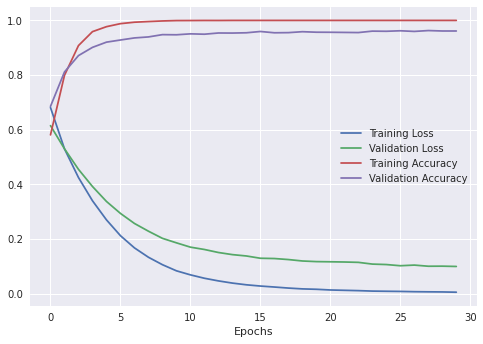

In [8]:
with plt.style.context('seaborn'):    
    plt.plot(train_losses,label='Training Loss')
    plt.plot(val_losses,label='Validation Loss')
    plt.plot(train_accuracies,label='Training Accuracy')
    plt.plot(val_accuracies,label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
plt.show()

In [9]:
# testing validation bias
model.eval()
val_predictions = []
with torch.no_grad():
    for X_val, y_val,_ in val_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)
        val_out = model(X_val)
        val_pred = torch.round(torch.sigmoid(val_out)).detach().cpu().numpy().flatten()
        val_predictions.append(val_pred)

In [10]:
len(val_loader)

191

In [11]:
val_predictions = np.array(val_predictions).flatten()
val_df['predictions'] = val_predictions
val_df

,index,reference_identity,candidate_identity,reference_ethnicity,candidate_ethnicity,reference_gender,candidate_gender,labels,predictions
4764,9564,n003329,n003329,white,white,male,male,1.0,1.0
10984,22012,n001016,n005887,white,white,female,female,0.0,0.0
18558,37318,n009112,n002688,black,black,male,male,0.0,0.0
18799,37791,n004532,n004244,black,black,female,female,0.0,1.0
17662,35449,n004180,n007606,white,white,male,male,0.0,0.0
...,...,...,...,...,...,...,...,...,...
15392,30866,n000371,n004546,black,black,female,female,0.0,0.0
9120,18720,n000680,n000680,white,white,female,female,1.0,1.0
11892,23856,n008767,n003396,white,white,male,male,0.0,0.0
4929,12129,n002227,n002227,black,black,female,female,1.0,1.0


In [12]:
black_val_df = val_df[val_df['reference_ethnicity']=='black']
# black_val_df = val_df[val_df['reference_ethnicity']=='black']
# indian_val_df = val_df[val_df['reference_ethnicity']=='indian']
white_val_df = val_df[val_df['reference_ethnicity']=='white']
male_val_df = val_df[val_df['reference_gender']=='male']
female_val_df = val_df[val_df['reference_gender']=='female']

In [13]:
black_val_preds = black_val_df.predictions
# black_val_preds = black_val_df.predictions
# indian_val_preds = indian_val_df.predictions
white_val_preds = white_val_df.predictions
male_val_preds = male_val_df.predictions
female_val_preds = female_val_df.predictions

black_val_labels = black_val_df.labels
# black_val_labels = black_val_df.labels
# indian_val_labels = indian_val_df.labels
white_val_labels = white_val_df.labels
male_val_labels = male_val_df.labels
female_val_labels = female_val_df.labels

black_tn, black_fp, black_fn, black_tp, black_acc = confusion_mat(black_val_preds,black_val_labels)
# black_tn, black_fp, black_fn, black_tp, black_acc = confusion_mat(black_val_preds,black_val_labels)
# indian_tn, indian_fp, indian_fn, indian_tp, indian_acc = confusion_mat(indian_val_preds,indian_val_labels)
white_tn, white_fp, white_fn, white_tp, white_acc = confusion_mat(white_val_preds,white_val_labels)
male_tn, male_fp, male_fn, male_tp, male_acc = confusion_mat(male_val_preds,male_val_labels)
female_tn, female_fp, female_fn, female_tp, female_acc = confusion_mat(female_val_preds,female_val_labels)

black_tnr = black_tn/(black_tn+black_fp)
black_tpr = black_tp/(black_tp+black_fn)
black_fnr = black_fn/(black_fn+black_tp)
black_fpr = black_fp/(black_fp+black_tn)

# black_tnr = black_tn/(black_tn+black_fp)
# black_tpr = black_tp/(black_tp+black_fn)
# black_fnr = black_fn/(black_fn+black_tp)
# black_fpr = black_fp/(black_fp+black_tn)

# indian_tnr = indian_tn/(indian_tn+indian_fp)
# indian_tpr = indian_tp/(indian_tp+indian_fn)
# indian_fnr = indian_fn/(indian_fn+indian_tp)
# indian_fpr = indian_fp/(indian_fp+indian_tn)

white_tnr = white_tn/(white_tn+white_fp)
white_tpr = white_tp/(white_tp+white_fn)
white_fnr = white_fn/(white_fn+white_tp)
white_fpr = white_fp/(white_fp+white_tn)

male_tnr = male_tn/(male_tn+male_fp)
male_tpr = male_tp/(male_tp+male_fn)
male_fnr = male_fn/(male_fn+male_tp)
male_fpr = male_fp/(male_fp+male_tn)

female_tnr = female_tn/(female_tn+female_fp)
female_tpr = female_tp/(female_tp+female_fn)
female_fnr = female_fn/(female_fn+female_tp)
female_fpr = female_fp/(female_fp+female_tn)

In [14]:
print(f'black TNR: {black_tnr:.3f} | black TPR: {black_tpr:.3f} ')
print(f'black FNR: {black_fnr:.3f} | black FPR: {black_fpr:.3f} ')

# print(f'black TNR: {black_tn/(black_tn+black_fp):.3f} | black TPR: {black_tp/(black_tp+black_fn):.3f} ')
# print(f'black FNR: {black_fn/(black_fn+black_tp):.3f} | black FPR: {black_fp/(black_fp+black_tn):.3f} ')

# print(f'indian TNR: {indian_tn/(indian_tn+indian_fp):.3f} | indian TPR: {indian_tp/(indian_tp+indian_fn):.3f} ')
# print(f'indian FNR: {indian_fn/(indian_fn+indian_tp):.3f} | indian FPR: {indian_fp/(indian_fp+indian_tn):.3f} ')

print(f'white TNR: {white_tn/(white_tn+white_fp):.3f} | white TPR: {white_tp/(white_tp+white_fn):.3f} ')
print(f'white FNR: {white_fn/(white_fn+white_tp):.3f} | white FPR: {white_fp/(white_fp+white_tn):.3f} ')

black TNR: 0.937 | black TPR: 0.975 
black FNR: 0.025 | black FPR: 0.063 
white TNR: 0.963 | white TPR: 0.969 
white FNR: 0.031 | white FPR: 0.037 


In [15]:
((0.074-0.043 ) + (0.955-0.971))/2

0.007499999999999993

In [16]:
print(black_fnr/white_fnr)
# print(black_fnr/white_fnr)
# print(indian_fnr/white_fnr)
print()
print(black_fpr/white_fpr)
# print(black_fpr/white_fpr)
# print(indian_fpr/white_fpr)
print()
print(black_tnr/white_tnr)
# print(black_tnr/white_tnr)
# print(indian_tnr/white_tnr)
print()
print(black_tpr/white_tpr)
# print(black_tpr/white_tpr)
# print(indian_tpr/white_tpr)

0.8125786163522013

1.7089778586593876

0.9730280162466537

1.00598790363092


In [17]:
print(f'male TNR: {male_tn/(male_tn+male_fp):.3f} | male TPR: {male_tp/(male_tp+male_fn):.3f} ')
print(f'male FNR: {male_fn/(male_fn+male_tp):.3f} | male FPR: {male_fp/(male_fp+male_tn):.3f} ')

print(f'female TNR: {female_tn/(female_tn+female_fp):.3f} | female TPR: {female_tp/(female_tp+female_fn):.3f} ')
print(f'female FNR: {female_fn/(female_fn+female_tp):.3f} | female FPR: {female_fp/(female_fp+female_tn):.3f} ')

male TNR: 0.950 | male TPR: 0.974 
male FNR: 0.026 | male FPR: 0.050 
female TNR: 0.951 | female TPR: 0.970 
female FNR: 0.030 | female FPR: 0.049 


In [18]:
((0.067-0.051)+(0.952-0.973))/2

-0.0025000000000000057

In [19]:
print(female_fnr/male_fnr)
print()
print(female_fpr/male_fpr)
print()
print(female_tnr/male_tnr)
print()
print(female_tpr/male_tpr)

1.173347280334728

0.9947423764458464

1.0002748701969357

0.9953994883138342


In [20]:
torch.save(model,'weights/black_white_logistic_regression_face_matching.pt')
